# Algorithms for efficient entropy conversion

By Calum Grant, June 2025

This page is to reproduce the results of the accompanying paper.

The code is in the accompanying [entropy.py](entropy.py) file. We'll import it as follows:

In [56]:
from entropy import *

## Basic entropy operations

The basic operations are provided by `combine()`, `divide()`, `resample()` functions.

In [57]:
def combine(U_n, n, U_m, m):
    return U_n * m + U_m, n*m

def divide(U_nm, nm, n):
    U_m, U_n = divmod(U_nm, n)
    m = nm // n
    return U_m, m, U_n

def resample(U_n, n, m):
    if U_n < n:
        B = True
        x = m
        U_x = U_n
    else:
        B = False
        x = m-n
        U_x = U_n - m
    return U_x, x, B

We'll also create a `fetch()` function that returns one bit of entropy, and now we have `generate_uniform()` to create perfectly uniform random variables of the given size! In this example, we're just using the built-in `random` module but we could fetch hardware entropy if we wanted to.

In [58]:
import random
U_s = 0
s = 1
bits_fetched = 0
N = 1<<31

def fetch():
    global bits_fetched
    bits_fetched += 1
    return random.randint(0,1)

def generate_uniform(U_s, s, n):
    while True:
        while s < N:
            U_s, s = combine(U_s, s, fetch(), 2)
        U_s, s, b = downsample(U_s, s, s % n)
        if not b:
            U_s, s, U_n = divide(U_s, s, n) 
            return U_s, s, U_n

Let's just test it

In [59]:
U_s, s, x = generate_uniform(U_s, s, 6)
x

4

Let's test it on a larger sample. It's not the most rigourous test, but we would expect around 100 in each bin. Remember we've proven the correctness of this algorithm, so it's just to make sure we haven't messed up the implementation somewhere.

In [60]:
counts = [0,0,0,0,0,0]
for i in range (0,600):
    U_s, s, x = generate_uniform(U_s, s, 6)
    counts[x] += 1
counts

[93, 100, 113, 112, 114, 68]

## Distributions

The `entropy` module also defines the distributions `U` and `B`. We can construct `U` objects manually as follows:

In [61]:
U(4,6)

U(6)

The default `U` object has size 1, which means it has no entropy.

In [62]:
U()

U(1)

We can measure the stored entropy using the `entropy()` method:

In [63]:
U().entropy()

0.0

In [64]:
U(1,6).entropy()

2.584962500721156

Whenever you read or consume the entropy, the original entropy becomes empty (`U(1)`). This is to prevent errors reusing the same entropy.

In [65]:
x = U(1,6)
x.entropy()
x.read()

1

Calling `read()` turned `x` into a pumpkin!

In [66]:
x


U(1)

In [67]:
x.entropy()

0.0

The basic entropy operations are implemented on `U`:

In [68]:
U(1,6).combine(U(2,6))

U(36)

In [69]:
U(10,36).downsample(10)

(U(26), B(10/36))

In [70]:
U(9,36).downsample(10)

(U(10), B(10/36))

The entropy operations *destroy* the original entropy, to prevent errors.

In [71]:
x = U(1,6)
y = x.combine(U(3,6))
x

U(1)

# Calculating entropy for individual integers

The functions `expected_rejection_sampling()`, `expected_fast_dice_roller()` and `worst_case_eec()` calculate 
the expected entropy consumption for each integer generated. For example:

In [72]:
expected_rejection_sampling(3), expected_fast_dice_roller(3), worst_case_eec(3)

(2.6666666666666665, 2.6666259765625, 1.5849625300044479)

In [106]:
math.log2(6)/worst_case_eec(6)

0.999999972869868

Interestingly, `worst_case_eec` actually gives a entropy worse higher for powers of 2, but this is correct.

In [73]:
expected_rejection_sampling(4), expected_fast_dice_roller(4), worst_case_eec(4)

(2.0, 2, 2.0000000431077543)

Let's calculate the entropy efficiency generating the first 100 integers.

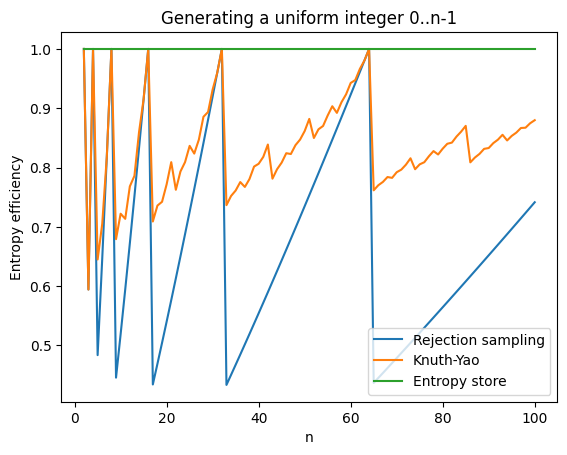

In [74]:
numbers = range(2,101)
rs_efficiency = [math.log2(n)/expected_rejection_sampling(n) for n in numbers]
fdr_efficiency = [math.log2(n)/expected_fast_dice_roller(n) for n in numbers]
eec_efficiency = [math.log2(n)/worst_case_eec(n) for n in numbers]

import matplotlib.pyplot as plt
plt.title('Generating a uniform integer 0..n-1')
plt.xlabel('n')
plt.ylabel('Entropy efficiency')
plt.plot(numbers, rs_efficiency, label='Rejection sampling')
plt.plot(numbers, fdr_efficiency, label='Knuth-Yao')
plt.plot(numbers, eec_efficiency, label='Entropy store')
plt.legend()
plt.savefig('uniform_efficiency.png')
plt.show()

In [101]:
math.log2(6)

2.584962500721156

In [102]:
expected_fast_dice_roller(6)

3.6666259765625

## Calculating entropy of card shuffling

Entropy of card shuffling just sums the entropy needed for a Fisher-Yates shuffling algorithm.

In [75]:
def expected_card_shuffling(n:int, expected) -> float:
    output = 0
    input = 0
    for i in range(2,n+1):
        output += math.log2(i)
        input += expected(i)   
    return output, input, output/input

Test it on a deck of 52 cards

In [76]:
expected_card_shuffling(52, expected_rejection_sampling)

(225.58100312370277, 355.90835089243757, 0.6338176740109078)

In [77]:
expected_card_shuffling(52, expected_fast_dice_roller)

(225.58100312370277, 277.8389933995495, 0.811912684981922)

In [78]:
expected_card_shuffling(52, worst_case_eec)

(225.58100312370277, 225.581020089913, 0.9999999247888398)

Now just draw a graph of decks size 2 to 100

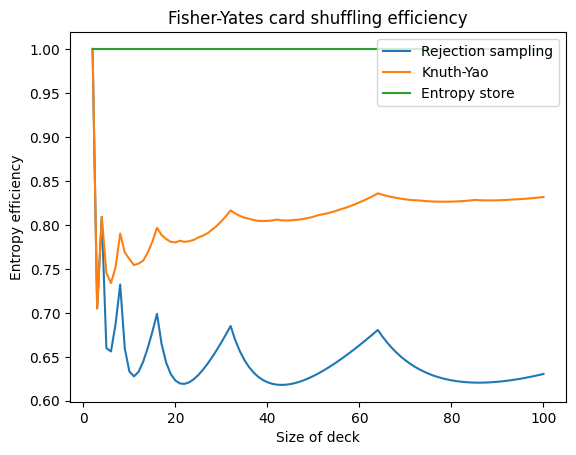

In [79]:
numbers = range(2,101)
rs_efficiency = [expected_card_shuffling(n, expected_rejection_sampling)[2] for n in numbers]
fdr_efficiency = [expected_card_shuffling(n, expected_fast_dice_roller)[2] for n in numbers]
eec_efficiency = [expected_card_shuffling(n, worst_case_eec)[2] for n in numbers]

plt.clf()
plt.title('Fisher-Yates card shuffling efficiency')

plt.xlabel('Size of deck')
plt.ylabel('Entropy efficiency')
plt.plot(numbers, rs_efficiency, label='Rejection sampling')
plt.plot(numbers, fdr_efficiency, label='Knuth-Yao')
plt.plot(numbers, eec_efficiency, label='Entropy store')
plt.legend(loc='upper right')
plt.savefig('shuffling_efficiency.png')
plt.show()

Let's look at the lost entropy now, using a log-log scale. (TODO)

## Simulations

We can implement entropy generators based on the above algorithms to see how they perform in practice. This is a good way to check the implementation for mistakes.

In [80]:
bin = BinaryEntropySource()

`MeasuringSource` wraps any entropy source and keeps track of how much entropy was delivered.

In [81]:
measured_input = MeasuringSource(bin)

In [82]:
rs = RejectionSamplingEntropySource(measured_input)
fdr = FastDiceRollerEntropySource(measured_input)
eec = EfficientEntropySource(measured_input)

Set up an entropy store based on rejection sampling and measure its outputs:

In [83]:
def measure_card_shuffle(input, output):
    input.entropy = 0
    output.entropy = 0
    shuffle(deck(), output)
    return input.entropy

measure_card_shuffle(measured_input, MeasuringSource(rs))

336.0

Note this will vary between runs.

In [84]:
measure_card_shuffle(measured_input, MeasuringSource(fdr))

271.0

Note this will vary between runs.

Let's measure how much entropy the efficient entropy converter uses to shuffle a deck:

In [85]:
eec.store = U()
measure_card_shuffle(measured_input, MeasuringSource(eec)) - eec.store.entropy()

225.58100347975855

Note that this is a little better than our calculated worst-case scenario, and a little worse than the theoretical limit of $\log_252!$.

Let's just see the `shuffle()` function in action:

In [86]:
src = EfficientEntropySource(bin)
d = deck()
shuffle(d, src)
''.join(d)

'iPBXTsevNGyWalFQbYOZxDdLVSRhCzMEmHpqAjufntkJgIUrcKow'

# Calculating entropy loss

In [87]:
def H_loss(p:float) -> float:
    return -(p/(1-p)) * math.log2(p) - math.log2(1-p)

def minefficiency(n, N) -> float:
    return math.log2(n) / (math.log2(n) + H_loss((n-1)/N))

In [88]:
H_loss((6-1)/(2**31))

7.013037571323212e-08

In [89]:
minefficiency(6, 2**31)

0.999999972869868

# Generating arbitrary distributions

The `make_distribution` function creates two additional lookup tables:

- a map from a uniform random number to the output number
- a map from the uniform random number to the first number in the range

The second table is needed when we recover a uniform distribution that must be recombined into the entropy store.

In [91]:
def make_distribution(weights):
    outputs = []
    offsets = []
    for i in range(0, len(weights)):
        start = len(outputs)
        for j in range(0, weights[i]):
            outputs.append(i)
            offsets.append(start)
    return weights, outputs, offsets

def generate_distribution(U_s, s, dist):
    weights, outputs, offsets = dist
    n = len(outputs)
    U_s, s, U_n = generate_uniform(U_s, s, n)
    U_s, s = combine(U_s, s, U_n-offsets[U_n], weights[outputs[U_n]])
    return U_s, s, outputs[U_n]

bits_fetched = 0
counts = [0,0,0]
dist = make_distribution([1,2,100])
for i in range(0,1000):
    U_s, s, n = generate_distribution(U_s, s, dist)
    counts[n] = counts[n]+1
print("Counts", counts)
print("Bits fetched=", bits_fetched)


Counts [12, 17, 971]
Bits fetched= 221


We can verify that the counts are roughly in proportion to the desired distribution. See how we only read 230 bits to generate 1000 digits. (Or whatever your RNG ended up doing).

Let's see how we can combine entropy from an arbitrary distributions back into the store.

In [96]:
def combine_distribution(U_s, s, dist, i):
    weights, outputs, offsets = dist
    U_s, s, U_x = generate_uniform(U_s, s, weights[i])
    U_s, s = combine(U_s, s, U_x + offsets[i], len(outputs))
    return U_s, s

dist = make_distribution([1,2])

U_s, s, n = generate_distribution(U_s, s, dist)
U_s, s = combine_distribution(U_s, s, dist, n)

Now let's implement a conversion function from one distribution to another

In [97]:
def convert_distribution(U_s, s, dist1, value, dist2):
    U_s, s = combine_distribution(U_s, s, dist1, value)
    return generate_distribution(U_s, s, dist2)

dist1 = make_distribution([1,3])
dist2 = make_distribution([1,2,3])
U_s, s, v1 = generate_distribution(U_s, s, dist1)
U_s, s, v2 = convert_distribution(U_s, s, dist1, v1, dist2)
v2

2